In [1]:
using Revise
includet("../cluster_env/runs/rg_unstructured//job.jl")

In [2]:
using CairoMakie
using GLMakie
CairoMakie.activate!()
# display(GLMakie.Screen(), f.figure)

# Setup

In [3]:
summerge(data) = reduce((a, b)->mergewith(+, a, b), data)
getratio(cs, dict) = sum(c->get(dict, c, 0), cs) / sum(values(dict))
getratio(c::Number, dict) = getratio((c,), dict)

getratio (generic function with 2 methods)

# Load data

In [6]:
# data = load_object("../cluster_env/runs/rg_unstructured/run1_shorter.jld2");
data = load_object("../cluster_env/runs/rg_unstructured/run3_N10_testing.jld2");
data

┌ 5×5×4×5×5×5 DimArray{Dict{Int64, Int64}, 6} ┐
├─────────────────────────────────────────────┴────────────────────────── dims ┐
  ↓ m Sampled{Float64} [0.0625, …, 4.0] ForwardOrdered Irregular Points,
  → c Sampled{Float64} [0.25, …, 64.0] ForwardOrdered Irregular Points,
  ↗ l Sampled{Float64} 0.0:0.3333333333333333:1.0 ForwardOrdered Regular Points,
  ⬔ si Sampled{Float64} 0.0:0.25:1.0 ForwardOrdered Regular Points,
  ◩ sr Sampled{Float64} 0.0:0.25:1.0 ForwardOrdered Regular Points,
  ⬒ sb Sampled{Float64} 0.0:0.25:1.0 ForwardOrdered Regular Points
└──────────────────────────────────────────────────────────────────────────────┘
[:, :, 1, 1, 1, 1]
 ↓ →       0.25                   1.0                    …  64.0
 0.0625     Dict(101=>100)         Dict(11=>2, 101=>98)       Dict(101=>100)
 0.176777   Dict(101=>100)         Dict(11=>1, 101=>99)       Dict(101=>100)
 0.5        Dict(101=>100)         Dict(101=>100)             Dict(101=>100)
 1.41421    Dict(101=>100)         Dict(101=>1

In [7]:
length(data)

12500

# First look

In [11]:
xx = summerge(data)

Dict{Int64, Int64} with 15 entries:
  -11   => 305
  -12   => 163
  1     => 722542
  23    => 63
  -1007 => 64
  11    => 1014
  -1    => 36
  -2    => 424
  -1004 => 346
  -23   => 14
  2     => 4007
  -22   => 456
  -13   => 40
  -21   => 1
  101   => 520525

In [12]:
(xx[101] + xx[1] + xx[2]) / sum(values(xx))

0.9976592

## Interactive phase-diagramy maps

In [23]:
xx = getratio.(101, data)
faa = plot_2ddimdata_heatmap_int(xx, :si, :sr;
    colorrange=(0., maximum(xx))
)
GLMakie.closeall()
display(GLMakie.Screen(), faa.figure)

GLMakie.Screen(...)

## Seeing the proportion of spatial instabilities

In [17]:
mur = getratio.(2, data)
maximum(mur)

0.2

In [18]:
faa = plot_2ddimdata_heatmap_int(mur, :si, :sr;
    colorrange=(0., maximum(mur))
)
GLMakie.closeall()
display(GLMakie.Screen(), faa.figure)

GLMakie.Screen(...)

In [16]:
faa = plot_2ddimdata_heatmap_int(mur, :c, :l;
    colorrange=(0., maximum(mur))
)
GLMakie.closeall()
display(GLMakie.Screen(), faa.figure)

GLMakie.Screen(...)

In [289]:
ext = getratio.(Ref((-101, 101)), data)

┌ 3×3×3×3×5×5×5 DimArray{Float64, 7} ┐
├────────────────────────────────────┴──────────────────────────── dims ┐
  ↓ N Sampled{Int64} [4, …, 20] ForwardOrdered Irregular Points,
  → m Sampled{Float64} [0.125, …, 8.0] ForwardOrdered Irregular Points,
  ↗ c Sampled{Float64} [0.125, …, 8.0] ForwardOrdered Irregular Points,
  ⬔ l Sampled{Float64} [0.0, …, 1.0] ForwardOrdered Irregular Points,
  ◩ si Sampled{Float64} 0.0:0.25:1.0 ForwardOrdered Regular Points,
  ⬒ sr Sampled{Float64} 0.0:0.25:1.0 ForwardOrdered Regular Points,
  ⬓ sb Sampled{Float64} 0.0:0.25:1.0 ForwardOrdered Regular Points
└───────────────────────────────────────────────────────────────────────┘
[:, :, 1, 1, 1, 1, 1]
  ↓ →  0.125  1.0   8.0
  4    0.01   0.72  1.0
 10    0.0    0.57  1.0
 20    0.01   0.39  0.98

In [291]:
faa = plot_2ddimdata_heatmap_int(ext, :si, :sr;
    colorrange=(0., maximum(ext))
)
GLMakie.closeall()
display(GLMakie.Screen(), faa.figure)

GLMakie.Screen(...)

# Running a single system

In [457]:
ps = rsg();

In [449]:
ps = params[1];

## No space solver

In [450]:
# Steady state
u0 = make_u0_smart(ps; u0=:onlyN)
ssp = make_mmicrm_ss_problem(ps, u0)
@time sss = solve(ssp, DynamicSS(QNDF());
    abstol=eps(),
    reltol=eps()
);
maximum(abs, sss.resid)

  4.895337 seconds (199.53 k allocations: 62.847 MiB)


4.877974151403349e-14

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase ~/.julia/packages/SciMLBase/m1Jrs/src/integrator_interface.jl:589


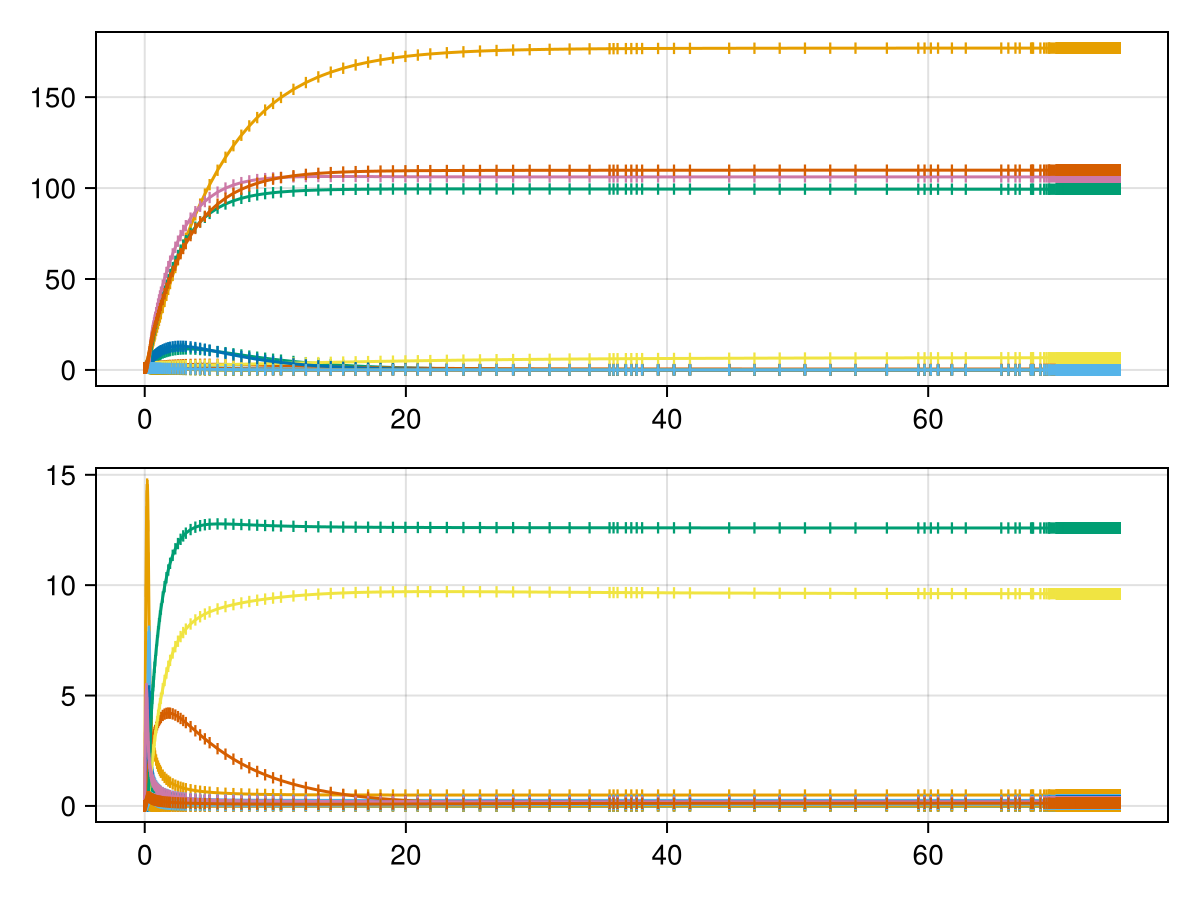

In [451]:
# Fixed time with evolution
u0 = make_u0_smart(ps; u0=:onlyN);
p = make_mmicrm_problem(ps, u0, 10000);
p = remake_guarantee_positive(p)

s = solve(p, QNDF())

f = plot_mmicrm_sol(s)
# display(GLMakie.Screen(), f)
f

## Spatial stuff

In [357]:
nssol = s.u[end];
# nssol = sss.u
xx = uninplace(mmicrmfunc!)(nssol, ps)
maxresid = maximum(abs, xx)
@show maxresid;

maxresid = 5.5780684779205136e-15


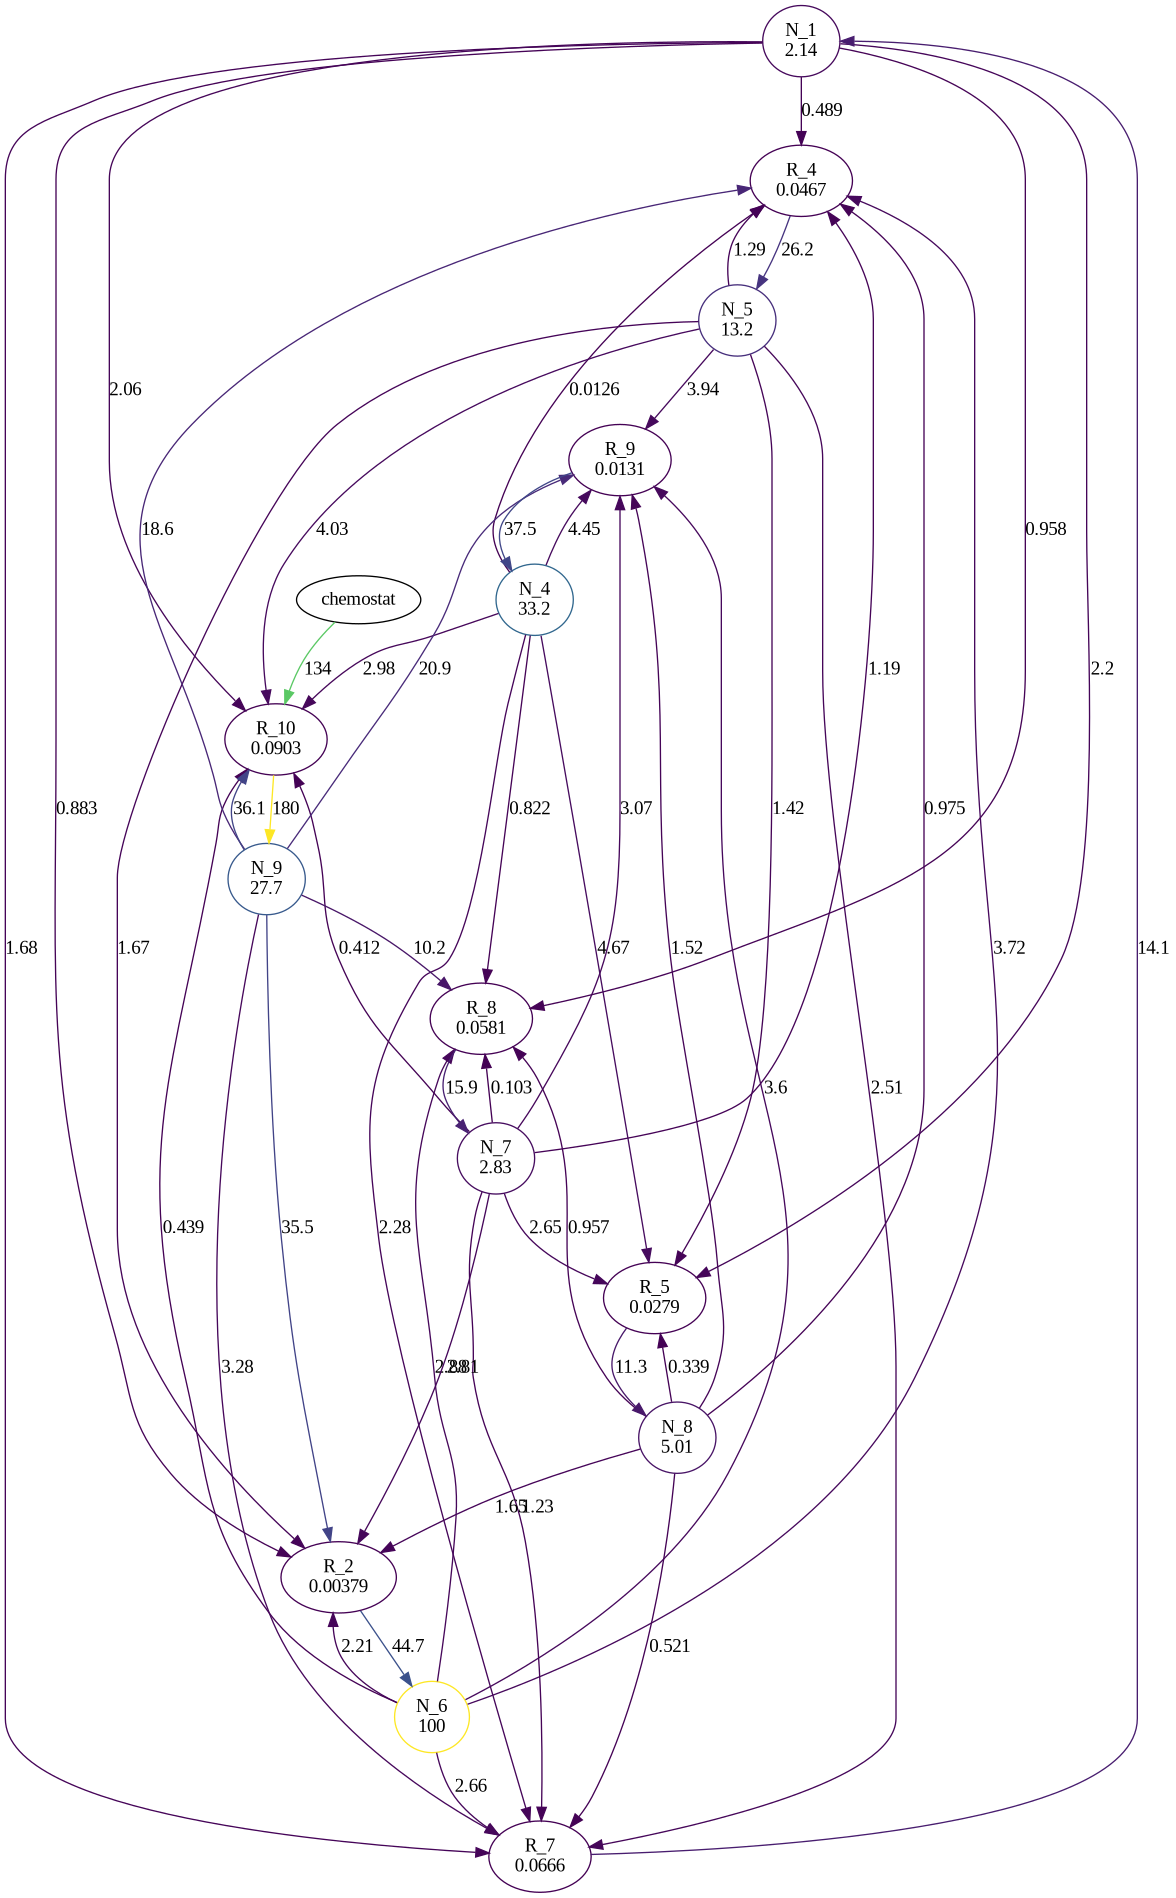

In [358]:
g = diagram_sfss_v3(ps, nssol;
    strain_threshold=1e-10
)

### Linear stability

In [418]:
ks = LinRange(0., 1000., 10000)

Ds = get_Ds(ps)
Ds = vcat(
    fill(1e-8, get_Ns(ps)[1]),
    fill(1e-8, get_Ns(ps)[2])
)
Ds[20] = 10000

lamfunc = linstab_make_k_func(ps, Ds, nssol)
lambdas = lamfunc.(ks);

maximum(x->maximum(real, x), lambdas)

-5.464753751148015e-5

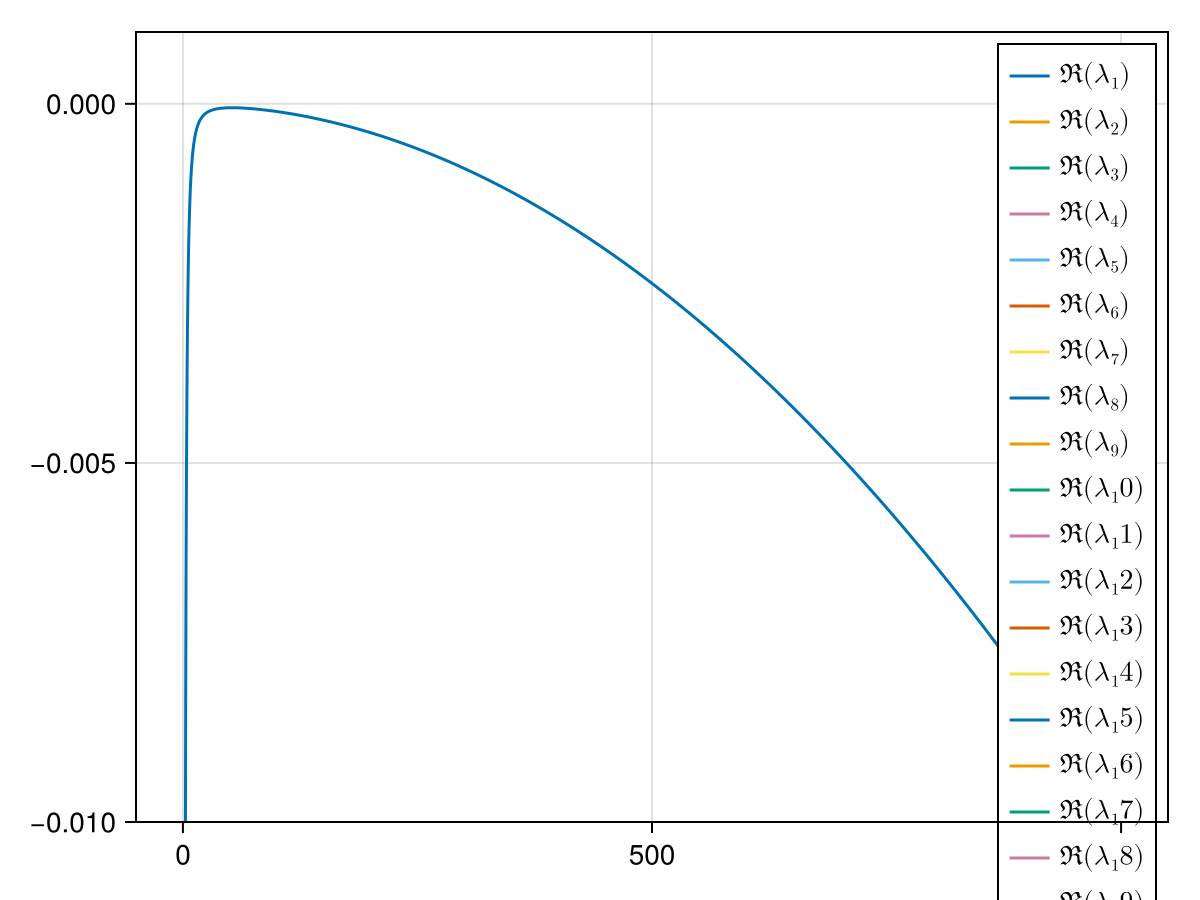

In [419]:
faa = plot_linstab_lambdas(ks, lambdas;
    imthreshold=Inf
)
# display(GLMakie.Screen(), faa.figure)
ylims!(faa.axis, -0.01, 0.001)
# xlims!(faa.axis, 0., 1000)
faa

### 1D spatial

In [349]:
ssize = (1000,)
dx = 0.01

# baseu0 = nssol
baseu0 = make_u0_smart(ps; u0=:onlyN)
su0 = expand_u0_to_size(ssize, baseu0)
su0 = perturb_u0_uniform_prop(get_Ns(ps)..., su0, 0.1, 0.1)


spaceps = change_bsmmicrmparams(ps; space=make_cartesianspace_smart(1;
    dx,
    bcs=Periodic()),
    usenthreads=nthreads()
)
@show spaceps.usenthreads spaceps.mmicrm_params.usenthreads

sp = make_smmicrm_problem(spaceps, su0, 100000);

spaceps.usenthreads = 18
spaceps.mmicrm_params.usenthreads = nothing


In [350]:
@time sps = solve(sp, QNDF());
print_spatial_solution_stats(sps)

  9.385754 seconds (13.18 M allocations: 3.611 GiB, 2.23% gc time, 129.82% compilation time)
Success
nf is 1030
solution has 155 saved states
max resid is 2.55048e-06


┌ Warning: reaching negative values, minimum is -3.34381e-07
└ @ SSMCMain.ModifiedMiCRM ~/UCLOneDrive/Projects/SSMC/src/SSMCMain/src/ModifiedMiCRM/util.jl:10


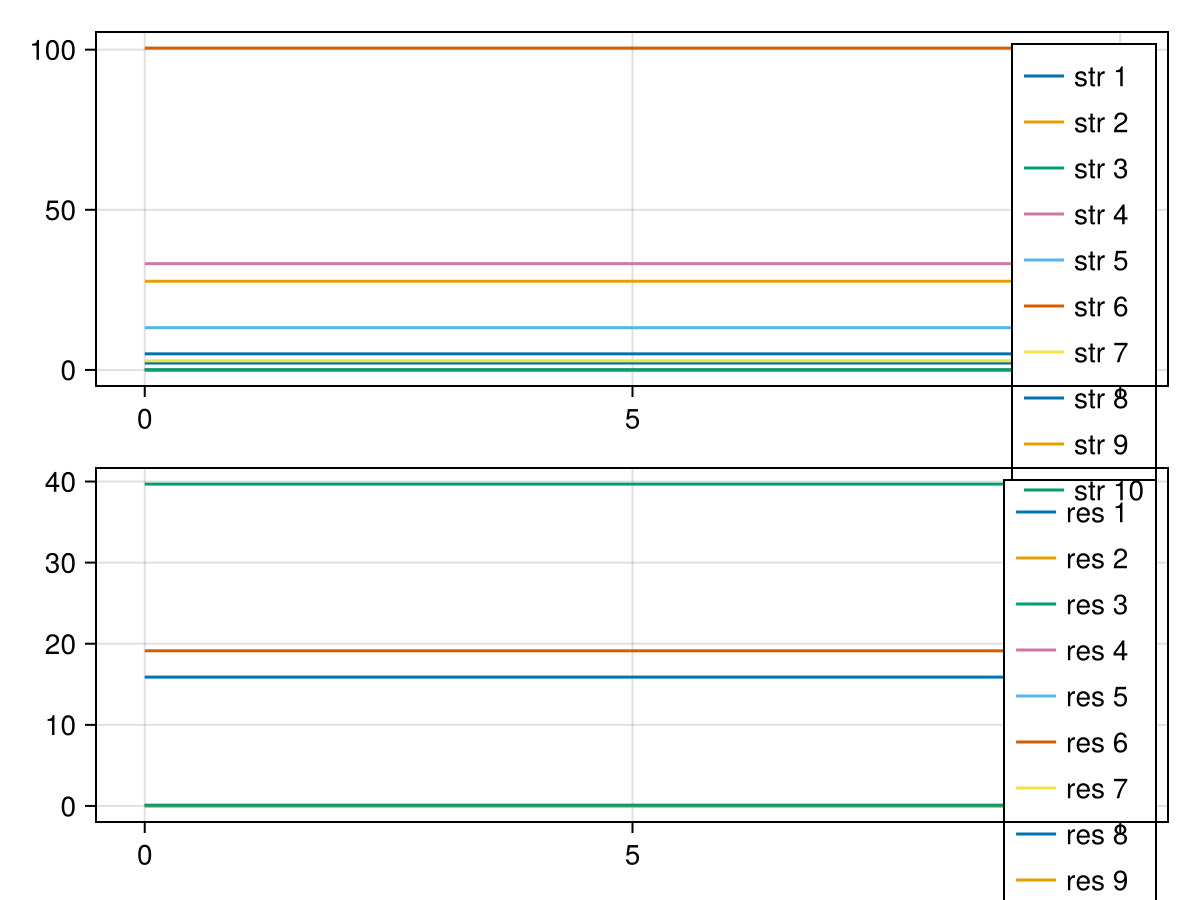

In [352]:
plot_1dsmmicrm_sol_snap(sps.prob.p, sps.u[end])

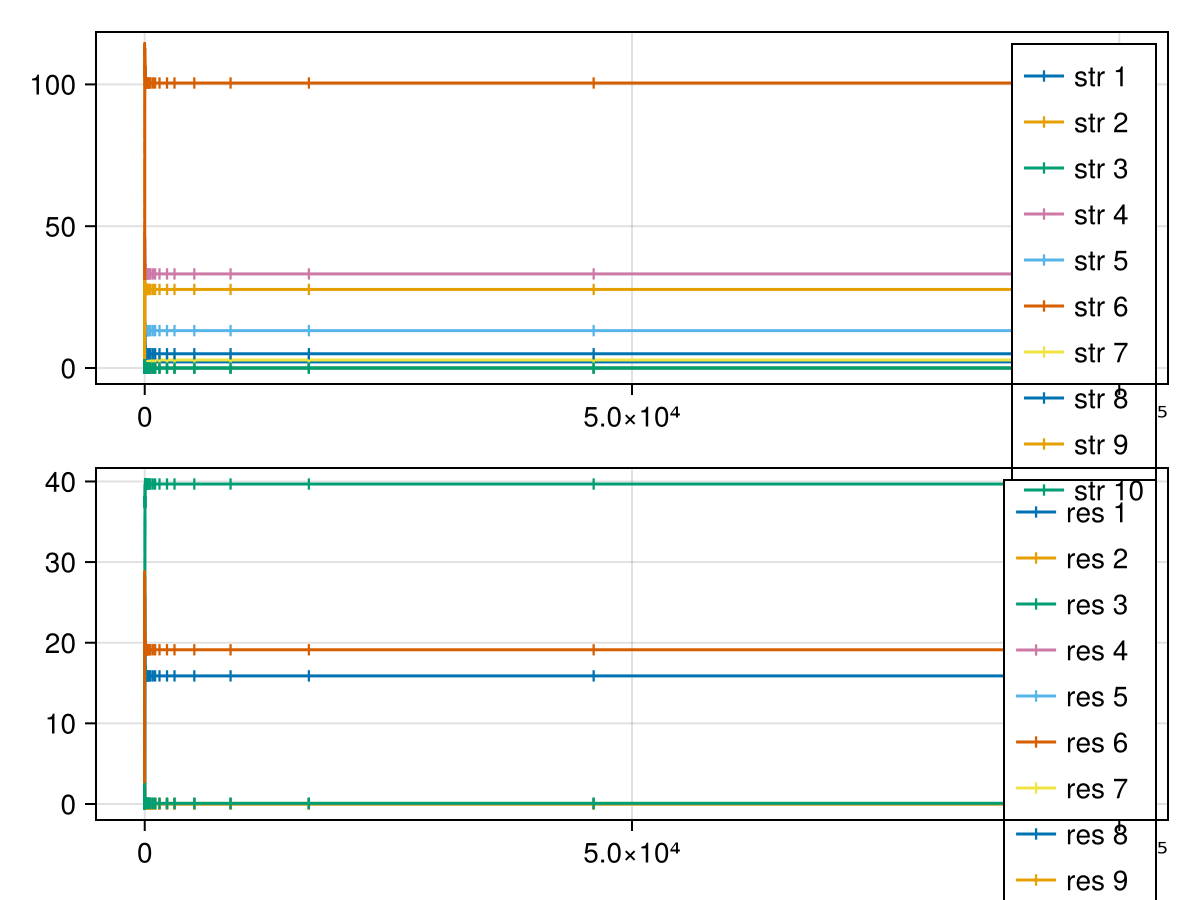

In [353]:
plot_smmicrm_sol_avgs(sps)

# Extras

In [189]:
GC.gc()
empty!(Out)
GC.gc()